In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
plt.style.use('seaborn-white')

<ipython-input-1-6d0fa4db7acd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
import morl
from env_FruitTree import FruitTree

use_B = False

In [91]:
d_FTN = 6

def main(n_rep: int):
    for i in range(1, 1 + n_rep):
        
        np.random.seed(i)
        
        policy = morl.make_policy_net(state_dim=2, 
                                      hidden_dim=140, 
                                      act_space=('discrete', 2), 
                                      c_dim=7, 
                                      seed=i,
                                      embed_dims=[10, 10], 
                                      std=0.2).to(morl.DEVICE)
        
        out = morl.learn(policy=policy, 
                         gradient_steps=20, 
                         n_grad_repeat=1, 
                         group_size_train=400, 
                         group_size_test=400, 
                         env=FruitTree(depth=d_FTN, noise_std=0.003, normalizer=lambda x: np.array([x[0]/d_FTN, x[1]/(2 ** x[0])])), 
                         n_obj=6, 
                         test_repeat=1, 
                         n_jobs=20, 
                         ep_len_train=np.inf, 
                         ep_len_test=np.inf, 
                         nn_k=10, 
                         beta=10.0, 
                         J_AU=np.zeros(6), 
                         J_U=np.zeros(6) + 1, 
                         gamma_train=0.99, 
                         gamma_test=0.99, 
                         mode='maxmin', 
                         score_clipped_above_zero=True,
                         use_QV=False, 
                         QV_params=None
                        )
        with open('out_{}.pkl'.format(i), 'wb') as f:
            pickle.dump(out, f)

In [ ]:
%%time
main(5)

In [95]:
outs = []
for i in range(1, 6):
    with open('out_{}.pkl'.format(i), 'rb') as f:
        outs += [pickle.load(f)]

In [96]:
[np.max(outs[i][0]) for i in range(5)]

[9301.940055037147,
 9302.378173357603,
 9302.378173357603,
 9287.629651228093,
 9302.378173357603]

In [97]:
np.mean([np.max(outs[i][0]) for i in range(5)])

9299.34084526761

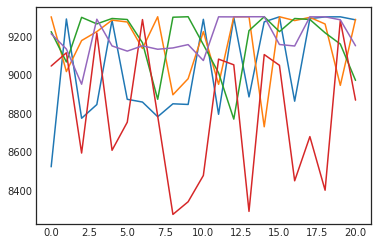

In [99]:
for i in range(5):
    plt.plot(outs[i][0])

In [100]:
_o = np.asarray([outs[i][0] for i in range(5)])

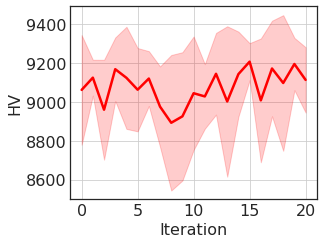

In [112]:
plt.figure(figsize=(4.6, 3.5))
#plt.xlim(0, 15)
#plt.xticks([0, 5, 10, 15, 20])
plt.tick_params(labelsize=16)
plt.grid()
plt.ylabel('HV', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.plot(_o.mean(axis=0), c='r', lw=2.5)
plt.fill_between(np.arange(21), 
                 _o.mean(axis=0) - _o.std(axis=0), 
                 _o.mean(axis=0) + _o.std(axis=0), alpha=0.2, color='r')
plt.tight_layout()
# plt.savefig('learning_fruit_{}.png'.format(d_FTN), dpi=400)

In [110]:
%%time
for i in [0, 3]:
    cs, all_R = morl.group_evaluation_REPEAT(policy=outs[0][2], group_size=1500, n_jobs=20, 
                                             env=FruitTree(depth=d_FTN, noise_std=0.003, 
                                                           normalizer=lambda x: np.array([x[0]/d_FTN, x[1]/(2 ** x[0])])).set_ep_len(np.inf), 
                                             seed=1, deterministic=True, n_obj=6, gamma=0.99, 
                                             n_episode_repeat=1)
    print(i, morl.HV(Rs=np.asarray(all_R), ref_point=np.zeros(6)))

0 9302.378173357603
3 9302.378173357603
CPU times: user 24min 57s, sys: 2.25 s, total: 24min 59s
Wall time: 25min
